In [1]:
!wget https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-29 10:13:56--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv.2’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-11-29 10:13:57 (44.4 MB/s) - ‘airline_passengers.csv.2’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

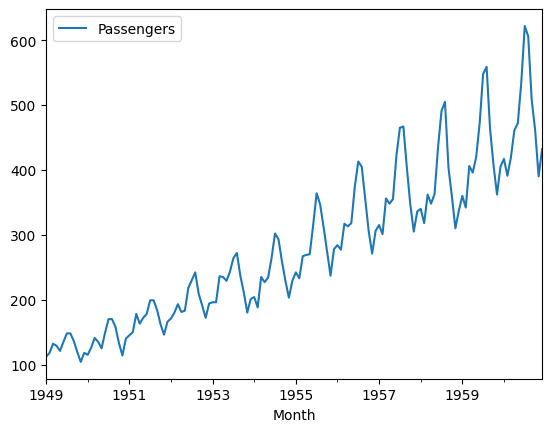

In [6]:
df.plot()

In [7]:
alpha = 0.2

In [8]:
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

In [9]:
type(df["Passengers"].ewm(alpha))

pandas.core.window.ewm.ExponentialMovingWindow

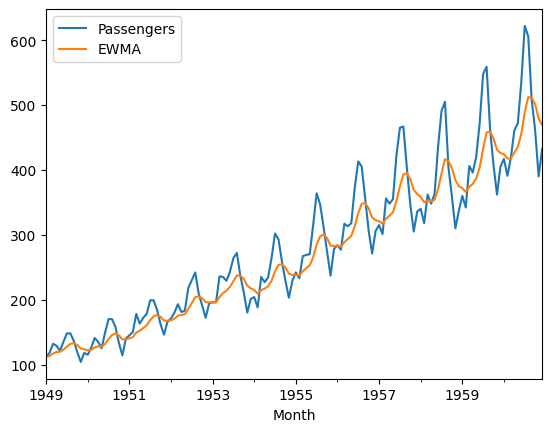

In [10]:
df.plot();

In [11]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [12]:
!pip install -U statsmodels

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [14]:
ses = SimpleExpSmoothing(df["Passengers"])

/home/peterb/Projects/time-series/airflow-venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
df.index.freq = "MS"

In [16]:
ses = SimpleExpSmoothing(df["Passengers"], initialization_method="legacy-heuristic")

In [17]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [18]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [19]:
df["SES"] = res.predict(start=df.index[0], end=df.index[-1])

In [20]:
np.allclose(df.SES, res.fittedvalues)

True

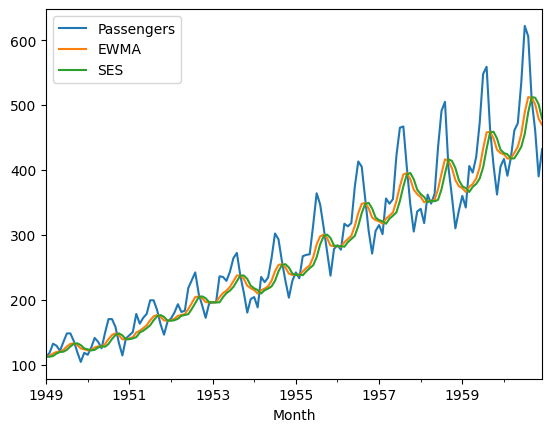

In [21]:
df.plot();

In [22]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [23]:
df["SES-1"] = df["SES"].shift(-1)

<Axes: xlabel='Month'>

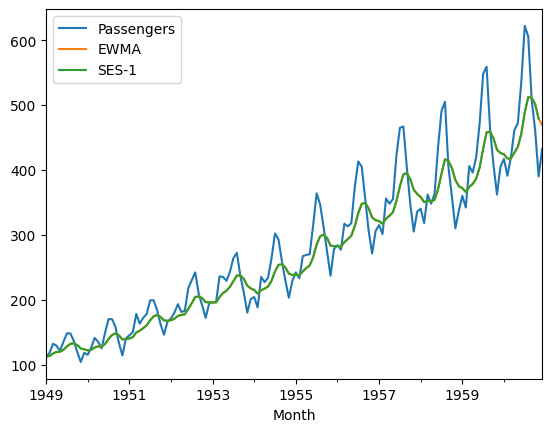

In [24]:
df[["Passengers", "EWMA", "SES-1"]].plot()

In [25]:
# treat like a ML model

In [26]:
n = 12
train = df.iloc[:-n]
test = df.iloc[-n:]

In [27]:
ses = SimpleExpSmoothing(
    train.Passengers,
    initialization_method="legacy-heuristic",
)

In [28]:
res = ses.fit()

In [29]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [30]:
df.loc[train_idx, "SESfitted"] = res.fittedvalues
df.loc[test_idx, "SESfitted"] = res.forecast(n)

<Axes: xlabel='Month'>

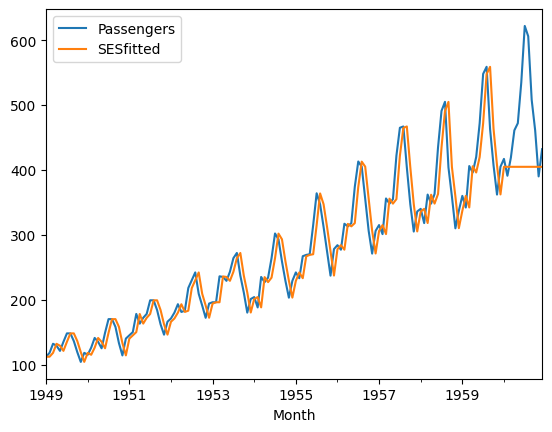

In [31]:
df[["Passengers", "SESfitted"]].plot()

In [32]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [33]:
len(train), len(test)

(132, 12)

In [34]:
train.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1959-03-01', '1959-04-01', '1959-05-01', '1959-06-01',
               '1959-07-01', '1959-08-01', '1959-09-01', '1959-10-01',
               '1959-11-01', '1959-12-01'],
              dtype='datetime64[ns]', name='Month', length=132, freq='MS')

In [35]:
df.SESfitted.tail(20)

Month
1959-05-01    396.048402
1959-06-01    419.880242
1959-07-01    471.739401
1959-08-01    547.618697
1959-09-01    558.943093
1959-10-01    463.479715
1959-11-01    407.282399
1959-12-01    362.226412
1960-01-01    404.786132
1960-02-01    404.786132
1960-03-01    404.786132
1960-04-01    404.786132
1960-05-01    404.786132
1960-06-01    404.786132
1960-07-01    404.786132
1960-08-01    404.786132
1960-09-01    404.786132
1960-10-01    404.786132
1960-11-01    404.786132
1960-12-01    404.786132
Freq: MS, Name: SESfitted, dtype: float64

In [36]:
from statsmodels.tsa.holtwinters import Holt

In [37]:
holt = Holt(df["Passengers"], initialization_method="legacy-heuristic")

In [38]:
res_h = holt.fit()

In [39]:
df["Holt"] = res_h.fittedvalues

<Axes: xlabel='Month'>

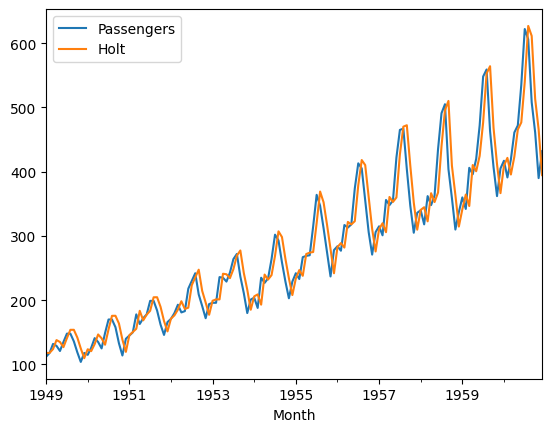

In [40]:
df[["Passengers", "Holt"]].plot()

In [41]:
res_h.forecast(n).values

array([436.19621982, 440.57865143, 444.96108305, 449.34351467,
       453.72594628, 458.1083779 , 462.49080951, 466.87324113,
       471.25567274, 475.63810436, 480.02053597, 484.40296759])

In [42]:
df.loc[test_idx, "Holt"] = res_h.forecast(n).values

<Axes: xlabel='Month'>

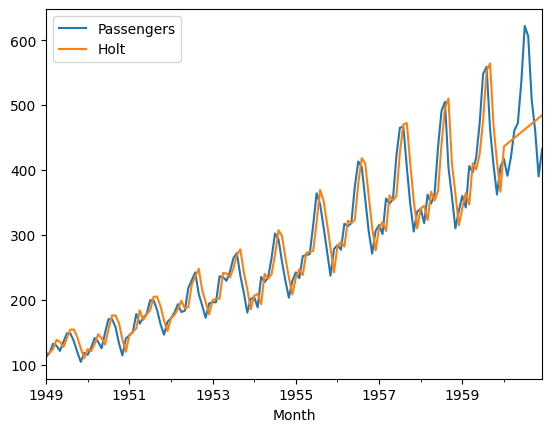

In [43]:
df[["Passengers", "Holt"]].plot()

In [44]:
df.tail(20)

,Passengers,EWMA,SES,SES-1,SESfitted,Holt
Month,,,,,,
1959-05-01,420,386.686354,378.357943,386.686354,396.048402,400.676434
1959-06-01,472,403.749084,386.686354,403.749084,419.880242,424.582057
1959-07-01,548,432.599267,403.749084,432.599267,471.739401,476.622293
1959-08-01,559,457.879413,432.599267,457.879413,547.618697,552.774169
1959-09-01,463,458.903531,457.879413,458.903531,558.943093,564.122368
1959-10-01,407,448.522825,458.903531,448.522825,463.479715,468.272849
1959-11-01,362,431.218260,448.522825,431.218260,407.282399,411.841516
1959-12-01,405,425.974608,431.218260,425.974608,362.226412,366.595181
1960-01-01,417,424.179686,425.974608,424.179686,404.786132,436.196220


In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [54]:
hw = ExponentialSmoothing(
    train["Passengers"],
    initialization_method="legacy-heuristic",
    trend="add",
    seasonal="add",
    # seasonal_periods=12,
)

In [55]:
res_hw = hw.fit()

In [56]:
df.loc[train_idx, "HoltWinters"] = res_hw.fittedvalues
df.loc[test_idx, "HoltWinters"] = res_hw.forecast(n).values

In [57]:
df

,Passengers,EWMA,SES,SES-1,SESfitted,Holt,HoltWinters
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,112.000000,112.000000,118.000000,113.083333
1949-02-01,118,113.200000,112.000000,113.200000,112.000000,118.007089,119.883184
1949-03-01,132,116.960000,113.200000,116.960000,117.970000,123.977209,134.463082
1949-04-01,129,119.368000,116.960000,119.368000,131.929850,137.967695,131.872718
1949-05-01,121,119.694400,119.368000,119.694400,129.014649,135.018254,124.150946
...,...,...,...,...,...,...,...
1960-08-01,606,512.214093,488.767616,512.214093,404.786132,466.873241,605.646938
1960-09-01,508,511.371274,512.214093,511.371274,404.786132,471.255673,506.174750
1960-10-01,461,501.297019,511.371274,501.297019,404.786132,475.638104,450.147481


<Axes: xlabel='Month'>

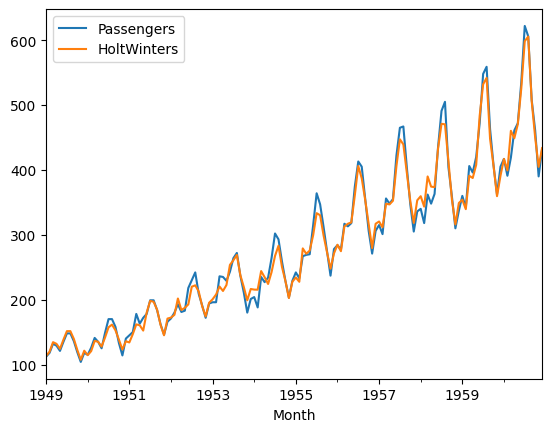

In [58]:
df[["Passengers", "HoltWinters"]].plot()